In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
print("[INFO]Loading images.....")
imagepaths=list(paths.list_images("G:\LBCS\Deep Learning\Fack Mask"))
data=[]
labels=[]

[INFO]Loading images.....


In [3]:
#loop the imagepath
for imagepath in imagepaths:
    #extract the class label from the filename
    label=imagepath.split(os.path.sep)[-2]
    
    #load the imput image(224x224) and preprocess it
    image=load_img(imagepath, target_size=(224, 224))
    image=img_to_array(image)
    image=preprocess_input(image)
    
    #update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [4]:
#convert the data and labels to Numpy arrys
data=np.array(data, dtype="float32")
labels=np.array(labels)

#preform one-hot encoding on the label 
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [5]:
#the data for training and the remaining 25% for testing 
(train_x,test_x,train_y,test_y)=train_test_split(data, labels,
                                                 test_size=0.20, stratify=labels, random_state=45)

In [6]:
#construct the training image generator for data augumentation
aug=ImageDataGenerator(rotation_range=20, zoom_range=0.15, 
                      width_shift_range=0.2, height_shift_range=0.2, 
                      shear_range=0.15, horizontal_flip=True, fill_mode="neareast")

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
baseModel=MobileNet(weights='imagenet',include_top=False, input_tensor=Input(shape=(224,224,3)))

In [8]:
#construct the head of the model that will be places on top of the base model
headmodel=baseModel.output
headmodel=AveragePooling2D(pool_size=(7, 7))(headmodel)
headmodel=Flatten(name="flatten")(headmodel)
headmodel=Dense(128, activation="relu")(headmodel)
headmodel=Dropout(0.5)(headmodel)
headmodel=Dense(2, activation="softmax")(headmodel)

In [9]:
#loop over all layers in the base model and freeze them so they will "not" be Updated during the 
#first training process
for layer in baseModel.layers:
    layer.trainabel=False

In [10]:
#initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR=1e-4
EPOCHS=7
BS=32

#Compile your model
print("[info]Compile your model....")
opt=Adam(learning_rate=INIT_LR)
model=Model(inputs=baseModel.input,outputs=headmodel)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[info]Compile your model....


In [11]:
from scipy.ndimage import affine_transform

# Assuming you have defined train_x, train_y, test_x, and test_y somewhere in your code

# Define your augmentation parameters
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, 
                         horizontal_flip=True, fill_mode="nearest")

# Assuming you have defined model, BS, and EPOCHS somewhere in your code

# Fit the model with data augmentation
head = model.fit(aug.flow(train_x, train_y, batch_size=BS), 
                 steps_per_epoch=len(train_x) // BS, 
                 validation_data=(test_x, test_y), 
                 validation_steps=len(test_x) // BS, 
                 epochs=EPOCHS)


Epoch 1/7


24/24 [==============================] - 131s 4s/step - loss: 0.3200 - accuracy: 0.8725 - val_loss: 0.0976 - val_accuracy: 0.9799
Epoch 2/7
24/24 [==============================] - 69s 3s/step - loss: 0.0821 - accuracy: 0.9777 - val_loss: 0.0471 - val_accuracy: 0.9849
Epoch 3/7
24/24 [==============================] - 68s 3s/step - loss: 0.0581 - accuracy: 0.9816 - val_loss: 0.0293 - val_accuracy: 0.9950
Epoch 4/7
24/24 [==============================] - 68s 3s/step - loss: 0.0362 - accuracy: 0.9882 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 5/7
24/24 [==============================] - 68s 3s/step - loss: 0.0213 - accuracy: 0.9961 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 6/7
24/24 [==============================] - 68s 3s/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.0085 - val_accuracy: 0.9950
Epoch 7/7
24/24 [==============================] - 68s 3s/step - loss: 0.0097 - accuracy: 0.9987 - val_loss: 0.0029 - val_accuracy: 1.0000


In [12]:
#make predictions on the testing
predIdxs=model.predict(test_x)

7/7 [==============================] - 5s 536ms/step


In [13]:
#for each image in the testing set we need to find the indexof the 
#label with corresponding largest predicted probability
predIdxs=np.argmax(predIdxs, axis=1)

In [14]:
#show classification report
print(classification_report(test_y.argmax(axis=1),predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00        97
 WithoutMask       1.00      1.00      1.00       102

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199



In [15]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
args = {"model": "G:/LBCS/Deep Learning/Fack Mask/mask_detector.model"  # Specify the path where you want to save the model
       }
model.save(args["model"], save_format="h5")

[INFO] saving mask detector model...


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


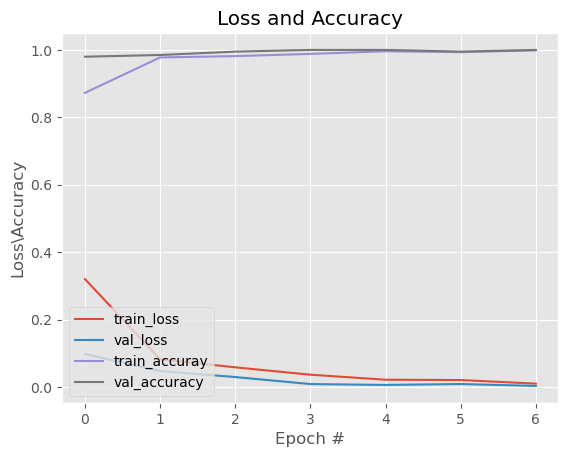

In [16]:
import matplotlib.pyplot as plt
#plot the loss and accuracy
N=EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N),head.history["loss"],label="train_loss")
plt.plot(np.arange(0, N),head.history["val_loss"],label="val_loss")
plt.plot(np.arange(0, N),head.history["accuracy"],label="train_accuray")
plt.plot(np.arange(0, N),head.history["val_accuracy"],label="val_accuracy")
plt.title("Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss\Accuracy")
plt.legend(loc="lower left")